# Recurrent Neural Networks (Built-in PyTorch Models)

**If you are a Colab user**

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

#%cd /content/drive/MyDrive/Colab\ Notebooks

This notebook implment various recurrent neural networks for a languages model.

1. **Data Pre-processing**: convert raw text data into corpus and vocabulary
2. **Training & Testing Datasets**: decompose the pre-processed data into train and test datasets
3. **Models**: define various recurrent neural network architectures and then wrap each as a language model
4. **Training & Testing Function**: define functions for training and testing the model
5. **Model Training**: Train the model
6. **Inferene**: Use the trained model

## Sequential Text Data Pre-processing

Students who are interested in language model can read through this section. Otherwise, details of this section can be skipped, and students only need to know that the raw text data have been converted into a sequence of indexed character or word tokens.

### Functions for Text Data Pre-processing

We define functions and classes that will be used for pre-processing text data. These include:
- Data Load Function (load_text): for loading the raw text data
- Data Clean Function (clean_text): for data cleaning
- Tokenization Function (tokenize): for split the cleaned text data into a sequence of tokens
- Vocabulary Class (Vocab): for creating the vocabulary wherein each unique token is assigned an ID
- Build Corpus and Vocabulary Function(build_time_machine): representing the sequence of tokens as a sequence of token IDs  by integrating the four functions and classes above.

#### Data Load Function

In [2]:
# read the raw text data from the data_path
def load_text(data_path):
    with open(data_path, 'r', encoding='utf-8') as f:
        text = f.read()
    return text

#### Data Clean Function

In [3]:
import re

def clean_text(text):
    """
    Removes leading/trailing metadata, normalizes punctuation,
    and retains only meaningful natural-language content.
    """

    # 1. Normalize line breaks    
    text = text.replace("\r", "\n")

    # 2. Split into paragraphs
    paragraphs = [p.strip() for p in text.split("\n")]

    # 3. Heuristic: keep only "content-like" paragraphs
    def is_content(p):
        return (
            len(re.findall(r"[A-Za-z]", p)) > 30 and
            not re.fullmatch(r"[A-Z \W]+", p)
        )

    valid_indices = [i for i,p in enumerate(paragraphs) if is_content(p)]

    if len(valid_indices) > 0:
        start = valid_indices[0]
        end   = valid_indices[-1] + 1
        paragraphs = paragraphs[start:end]

    # 4. Rejoin trimmed text
    text = " ".join(paragraphs)

    # 5. Remove non-ASCII
    text = re.sub(r"[^\x00-\x7F]+", " ", text)

    # 6. Normalize whitespace
    text = re.sub(r"\s+", " ", text)

    # 7. Restrict punctuation
    text = re.sub(r"[^a-zA-Z0-9.,!?\'\\ ]+", "", text)

    # 8. Lowercase all text
    text = text.lower().strip()

    return text


#### Tokenization Function

*Tokens* are the atomic (indivisible) units of text. Each time step corresponds to 1 token, but what precisely constitutes a token is a design choice. For example, we could represent the sentence "Department of Civil engineering at Stony Brook University" as a sequence of 8 words, where the set of all words comprise a large vocabulary (typically tens or hundreds of thousands of words). Or we would represent the same sentence as a much longer sequence of 30 characters, using a much smaller vocabulary (there are only 256 distinct ASCII characters). 

We define the ``tokenize'' function for tokenizing the cleaned text data

In [4]:
def tokenize(text, token='word'):
    """
    Split text into tokens.
    """
    
    if token == 'word':
        return [line.strip().lower().split() for line in text.split('\n') if line.strip()]
    elif token == 'char':
        return [list(line.strip().lower()) for line in text.split('\n') if line.strip()]
    else:
        raise ValueError("token argument must be either 'word' or 'char'")


#### Vocabulary Function

These tokens are still strings. However, the inputs to our models must ultimately consist of numerical inputs. We construct vocabularies by associating each distinct token value with a unique index.

First, we determine the set of unique tokens in our training corpus. We then assign a numerical index to each unique token.

Rare vocabulary elements are often dropped for convenience.

Whenever we encounter a token at training or test time that had not been previously seen or was dropped from the vocabulary, we represent it by a special "<unk>" token, signifying that this is an unknown value.

In [5]:
import collections
import re

class Vocab:
    """
    A modular vocabulary class for NLP.
    """

    def __init__(self, tokens=None, min_freq=1, reserved_tokens=None, char_level=False):
        reserved_tokens = reserved_tokens or []

        if tokens is None:
            tokens = []

        if isinstance(tokens, str):
            if char_level:
                tokens = list(tokens)
            else:
                tokens = tokens.split()

        elif len(tokens) > 0 and isinstance(tokens[0], list):
            if char_level:
                tokens = [ch for line in tokens for token in line for ch in token]
            else:
                tokens = [tok for line in tokens for tok in line]

        elif isinstance(tokens, list) and char_level:
            tokens = [ch for token in tokens for ch in token]

        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)

        self.idx_to_token = ['<unk>']
        self.idx_to_token += reserved_tokens

        for token, freq in self.token_freqs:
            if freq >= min_freq and token not in self.idx_to_token:
                self.idx_to_token.append(token)

        self.token_to_idx = {tok: i for i, tok in enumerate(self.idx_to_token)}
        self.char_level = char_level

    def __len__(self):
        return len(self.idx_to_token)

    @property
    def unk(self):
        return self.token_to_idx['<unk>']

    def __getitem__(self, x):
        if isinstance(x, (list, tuple)):
            return [self.__getitem__(elem) for elem in x]
        return self.token_to_idx.get(x, self.unk)

    def to_tokens(self, x):
        if isinstance(x, (list, tuple)):
            return [self.to_tokens(elem) for elem in x]
        return self.idx_to_token[int(x)]


#### Build Corpus and Vocabulary 

In [6]:
def build_corpus_vocabulary(data_path, token='char', vocab=None):
    """
    Build corpus and vocabulary.
    """
    
    raw_text = load_text(data_path)
    text = clean_text(raw_text)
    tokens = tokenize(text, token=token)

    if vocab is None:
        vocab = Vocab(tokens)
    
    corpus = [idx for line in tokens for idx in vocab[line]]

    return corpus, vocab


### The Time Machine

#### Download Data

In [7]:
import os
import requests

url = "https://www.gutenberg.org/files/35/35-0.txt"
response = requests.get(url)
data_path = os.path.join("Data", "time_machine.txt")

with open(data_path, "w", encoding="utf-8") as f:
    f.write(response.text)

print(f"Data Downloading ...")
print(f"Book saved as {data_path}\n")

Data Downloading ...
Book saved as Data/time_machine.txt



#### Build Corpus and Vocabulary

In [8]:
data_path = "Data/time_machine.txt"
corpus, vocab = build_corpus_vocabulary(data_path, token='word')

print(f"Corpus length: {len(corpus)}\n")
print(f"Vocabulary size: {len(vocab)}\n")
print(f"First 10 indices: {corpus[:10]}\n")
print(f"Fits 10 tokens: {vocab.to_tokens(corpus[:10])}\n")
print("Top 10 frequent tokens:")
vocab.token_freqs[:10]

Corpus length: 32750

Vocabulary size: 6277

First 10 indices: [1016, 4, 1, 2438, 2439, 2440, 2441, 1, 18, 82]

Fits 10 tokens: ['start', 'of', 'the', 'project', 'gutenberg', 'ebook', '35', 'the', 'time', 'machine']

Top 10 frequent tokens:


[('the', 2285),
 ('i', 1256),
 ('and', 1221),
 ('of', 1161),
 ('a', 818),
 ('to', 683),
 ('in', 542),
 ('was', 540),
 ('my', 441),
 ('that', 420)]

## Prepare Training and Validation Data

### Data Partitioning

In this section, we split the sequence of tokens into non-overlapping subsequences that each conmprises a number of tokens. Given the observation of a subsequence, we hope to predict the next token. Therefore, we shift each subsequence forward by one token to obtain the groundtruth for prediction.

In [9]:
import torch
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, corpus, num_tokens):
        """
        Random-offset non-overlapping subsequence partitioning.
        """
        self.corpus = torch.tensor(corpus, dtype=torch.long)
        self.num_tokens = num_tokens
        self.reset_epoch()

    def reset_epoch(self):
        """Randomly choose offset d and rebuild subsequences."""
        n = self.num_tokens
        T = len(self.corpus)

        self.d = torch.randint(0, n, (1,)).item()
        trimmed = self.corpus[self.d:]
        m = (len(trimmed) - 1) // n
        usable = m * n

        X = trimmed[:usable].reshape(m, n)
        Y = trimmed[1 : usable + 1].reshape(m, n)

        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


### Define Data Loader

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader


def get_dataloader(corpus, num_tokens, batch_size=32, train_ratio=0.7):
    dataset = MyDataset(corpus, num_tokens)
    N = len(dataset)

    num_train = int(N * train_ratio)
    num_val = N - num_train

    train_set = torch.utils.data.Subset(dataset, range(0, num_train))
    val_set   = torch.utils.data.Subset(dataset, range(num_train, N))

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, dataset


## Model Development

In this section, we define different recurrent neural networks, as well as a language model wrapper 

In [11]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

### RNN Models

In [12]:
# BaseRNN interface

class BaseRNN(nn.Module):
    def __init__(self):
        super().__init__()

    def begin_state(self, batch_size, device):
        raise NotImplementedError

#### RNN

In [13]:
class RNN(BaseRNN):
    def __init__(self, embed_size, num_hiddens, num_layers=2, dropout=0.3):
        """
        Wrapper for PyTorch's built-in nn.RNN
        """
        super().__init__()
        self.num_inputs = embed_size
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers

        # PyTorch built-in RNN
        self.rnn = nn.RNN(
            input_size=embed_size,
            hidden_size=num_hiddens,
            num_layers=num_layers,
            batch_first=False,  # (subseq_len, batch, features)
            dropout=dropout if num_layers > 1 else 0
        )

    def forward(self, inputs, state):
        """
        inputs: (subseq_len, batch_size, num_inputs) - one-hot encoded
        state: hidden state from previous step (or None)
        """
        # inputs shape: (subseq_len, batch_size, num_inputs)
        # state shape: (num_layers, batch_size, num_hiddens) if provided
        
        if state is None:
            # Let PyTorch initialize the hidden state
            output, state = self.rnn(inputs)
        else:
            # Convert list of hidden states to tensor
            if isinstance(state, list):
                state = torch.stack(state, dim=0)  # (num_layers, batch_size, num_hiddens)
            output, state = self.rnn(inputs, state)
        
        # output: (subseq_len, batch_size, num_inputs)
        # state: (num_layers, batch_size, num_hiddens)
        
        # Convert output to list of tensors (subseq timesteps)
        outputs = [output[t] for t in range(output.size(0))]
        
        # Convert state back to list format for consistency
        state_list = [state[i] for i in range(state.size(0))]
        
        return outputs, state_list

    def begin_state(self, batch, device):
        return [torch.zeros(batch, self.num_hiddens, device=device)
                for _ in range(self.num_layers)]


#### LSTM

In [14]:
class LSTM(BaseRNN):
    """LSTM with embedding support and dropout."""
    
    def __init__(self, embed_size, num_hiddens, num_layers=2, dropout=0.3):
        super().__init__()
        self.embed_size = embed_size
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size=embed_size,
            hidden_size=num_hiddens,
            num_layers=num_layers,
            batch_first=False,
            dropout=dropout if num_layers > 1 else 0
        )
    
    def forward(self, inputs, state):
        if state is None:
            output, state = self.lstm(inputs)
        else:
            H, C = state
            if isinstance(H, list):
                H = torch.stack(H, dim=0)
                C = torch.stack(C, dim=0)
            output, (H, C) = self.lstm(inputs, (H, C))
            state = (H, C)
        
        outputs = [output[t] for t in range(output.size(0))]
        H, C = state
        H_list = [H[i] for i in range(H.size(0))]
        C_list = [C[i] for i in range(C.size(0))]
        return outputs, (H_list, C_list)
    
    def begin_state(self, batch, device):
        H = [torch.zeros(batch, self.num_hiddens, device=device)
             for _ in range(self.num_layers)]
        C = [torch.zeros(batch, self.num_hiddens, device=device)
             for _ in range(self.num_layers)]
        return (H, C)

#### GRU

In [15]:
class GRU(BaseRNN):
    """GRU with embedding support and dropout."""
    
    def __init__(self, embed_size, num_hiddens, num_layers=2, dropout=0.3):
        super().__init__()
        self.embed_size = embed_size
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        
        self.gru = nn.GRU(
            input_size=embed_size,
            hidden_size=num_hiddens,
            num_layers=num_layers,
            batch_first=False,
            dropout=dropout if num_layers > 1 else 0
        )
    
    def forward(self, inputs, state):
        if state is None:
            output, state = self.gru(inputs)
        else:
            if isinstance(state, list):
                state = torch.stack(state, dim=0)
            output, state = self.gru(inputs, state)
        
        outputs = [output[t] for t in range(output.size(0))]
        state_list = [state[i] for i in range(state.size(0))]
        return outputs, state_list
    
    def begin_state(self, batch, device):
        return [torch.zeros(batch, self.num_hiddens, device=device)
                for _ in range(self.num_layers)]

#### BiRNN

In [16]:
class BiRNN(nn.Module):
    def __init__(self, rnn_type, embed_size, num_hiddens, num_layers=2, dropout=0.3):
        super().__init__()
        self.num_inputs = embed_size
        self.num_hiddens = num_hiddens * 2  # bidirectional doubles hidden size
        self.num_layers = num_layers
        self.rnn_type = rnn_type
        
        if rnn_type == 'RNN':
            self.rnn = nn.RNN(
                input_size=embed_size,  # Fixed: was embed_size
                hidden_size=num_hiddens,
                num_layers=num_layers,
                batch_first=False,
                dropout=dropout if num_layers > 1 else 0,  # Added comma
                bidirectional=True
            )
        elif rnn_type == 'LSTM':
            self.rnn = nn.LSTM(
                input_size=embed_size,  # Fixed
                hidden_size=num_hiddens,
                num_layers=num_layers,
                batch_first=False,
                dropout=dropout if num_layers > 1 else 0,  # Added comma
                bidirectional=True
            )
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(
                input_size=embed_size,  # Fixed
                hidden_size=num_hiddens,
                num_layers=num_layers,
                batch_first=False,
                dropout=dropout if num_layers > 1 else 0,  # Added comma
                bidirectional=True
            )
    
    def forward(self, inputs, state=None):
        if state is None:
            output, state = self.rnn(inputs)
        else:
            if self.rnn_type == 'LSTM':
                H, C = state
                if isinstance(H, list):
                    # Fixed: use stack instead of cat
                    H = torch.stack(H, dim=0)
                    C = torch.stack(C, dim=0)
                output, (H, C) = self.rnn(inputs, (H, C))
                state = (H, C)
            else:
                if isinstance(state, list):
                    # Fixed: use stack instead of cat
                    state = torch.stack(state, dim=0)
                output, state = self.rnn(inputs, state)
        
        outputs = [output[t] for t in range(output.size(0))]
        
        if self.rnn_type == 'LSTM':
            H, C = state
            H_list = [H[i] for i in range(H.size(0))]
            C_list = [C[i] for i in range(C.size(0))]
            return outputs, (H_list, C_list)
        else:
            state_list = [state[i] for i in range(state.size(0))]
            return outputs, state_list
    
    def begin_state(self, batch, device):
        if self.rnn_type == 'LSTM':
            H = [torch.zeros(batch, self.num_hiddens // 2, device=device)
                 for _ in range(self.num_layers * 2)]
            C = [torch.zeros(batch, self.num_hiddens // 2, device=device)
                 for _ in range(self.num_layers * 2)]
            return (H, C)
        else:
            return [torch.zeros(batch, self.num_hiddens // 2, device=device)
                    for _ in range(self.num_layers * 2)]

### Language Model Wrapper

In [17]:
class LM(nn.Module):
    """Language Model with embedding layer."""
    
    def __init__(self, cell, vocab_size, embed_size=128, dropout=0.2):
        super().__init__()
        self.cell = cell
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        
        # Embedding layer - learns dense representations
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(dropout)
        
        # Output projection
        hidden_size = cell.num_hiddens
        self.output_proj = nn.Linear(hidden_size, vocab_size)
        
        # Initialize weights
        nn.init.uniform_(self.embedding.weight, -0.1, 0.1)
    
    def forward(self, X, state=None):
        # X: (batch, seq_len) token indices
        embs = self.dropout(self.embedding(X.T))  # (seq_len, batch, embed)
        outs, state = self.cell(embs, state)
        
        # Stack and project to vocabulary
        outs_stacked = torch.stack(outs, dim=1)
        logits = self.output_proj(outs_stacked)
        return logits, state

## Model Training

### Functions for Model Training

In [18]:
loss_fn = nn.CrossEntropyLoss()

# training in each step
def train_step(model, X, Y, optimizer, grad_clip_val, vocab_size, device):
    model.train()
    X, Y = X.to(device), Y.to(device)

    logits, _ = model(X, None)
    loss = loss_fn(logits.reshape(-1, vocab_size), Y.reshape(-1))

    optimizer.zero_grad()
    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_val)

    optimizer.step()

    ppl = torch.exp(loss.detach())
    return loss.item(), ppl.item()

# validation in each step
def val_step(model, X, Y, vocab_size, device):
    model.eval()
    X, Y = X.to(device), Y.to(device)

    with torch.no_grad():
        logits, _ = model(X, None)
        loss = loss_fn(logits.reshape(-1, vocab_size), Y.reshape(-1))
        ppl = torch.exp(loss)
    return loss.item(), ppl.item()

# Training over epochs
def train_model(model,
                corpus,
                num_tokens,
                vocab_size,
                batch_size=32,
                lr=1.0,
                epochs=50,
                grad_clip_val=1.0,
                device='cpu'):

    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    history = {"train_ppl": [], "val_ppl": [], "train_loss": [], "val_loss": []}

    for epoch in range(epochs):
        
        train_loader, val_loader, dataset = get_dataloader(corpus, num_tokens, batch_size=batch_size, train_ratio=0.7)

        train_loss = train_ppl = 0
        for X, Y in train_loader:
            loss, ppl = train_step(model, X, Y, optimizer,
                                   grad_clip_val, vocab_size, device)
            train_loss += loss
            train_ppl  += ppl
        train_loss /= len(train_loader)
        train_ppl  /= len(train_loader)

        val_loss = val_ppl = 0
        for X, Y in val_loader:
            loss, ppl = val_step(model, X, Y, vocab_size, device)
            val_loss += loss
            val_ppl  += ppl
        val_loss /= len(val_loader)
        val_ppl  /= len(val_loader)

        print(f"Epoch {epoch+1:03d} | Train PPL: {train_ppl:.2f} | Val PPL: {val_ppl:.2f}")

        history["train_ppl"].append(train_ppl)
        history["val_ppl"].append(val_ppl)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

    return history

# visualize training process
def plot_training_curves(history):
    epochs = range(1, len(history["train_ppl"]) + 1)
    plt.figure(figsize=(10,5))
    plt.plot(epochs, history["train_ppl"], label="Train PPL")
    plt.plot(epochs, history["val_ppl"], label="Val PPL")
    plt.xlabel("Epoch")
    plt.ylabel("Perplexity")
    plt.title("Training & Validation Perplexity")
    plt.legend()
    plt.grid(True)
    plt.show()

### Choose an RNN model

In [19]:
#my_model = RNN(embed_size=128, num_hiddens=256, num_layers=2, dropout=0.3)
#my_model = LSTM(embed_size=128, num_hiddens=256, num_layers=2, dropout=0.3)
my_model = GRU(embed_size=128, num_hiddens=256, num_layers=2, dropout=0.3)
#my_model = BiRNN(embed_size=128, rnn_type="RNN", num_hiddens=256, num_layers=2, dropout=0.3)
#my_model = BiRNN(embed_size=128, rnn_type="LSTM", num_hiddens=256, num_layers=2, dropout=0.3)
#my_model = BiRNN(embed_size=128, rnn_type="GRU", num_hiddens=256, num_layers=2, dropout=0.3)


### Build LM

In [20]:
# Create language model wrapper
device = 'cuda' if torch.cuda.is_available() else 'cpu'

lm_model = LM(my_model, vocab_size=len(vocab), embed_size=128, dropout=0.2).to(device)

print(f"Model parameters: {sum(p.numel() for p in lm_model.parameters()):,}")
print(f"Device: {device}")


Model parameters: 3,107,845
Device: cpu


### Train the Model

Epoch 001 | Train PPL: 6245.19 | Val PPL: 6229.66
Epoch 002 | Train PPL: 6211.89 | Val PPL: 6194.26
Epoch 003 | Train PPL: 6177.24 | Val PPL: 6159.22
Epoch 004 | Train PPL: 6143.97 | Val PPL: 6123.66
Epoch 005 | Train PPL: 6110.14 | Val PPL: 6087.21
Epoch 006 | Train PPL: 6076.09 | Val PPL: 6050.85
Epoch 007 | Train PPL: 6040.80 | Val PPL: 6014.12
Epoch 008 | Train PPL: 6005.12 | Val PPL: 5976.53
Epoch 009 | Train PPL: 5969.75 | Val PPL: 5936.62
Epoch 010 | Train PPL: 5931.69 | Val PPL: 5898.75
Epoch 011 | Train PPL: 5893.54 | Val PPL: 5858.72
Epoch 012 | Train PPL: 5854.21 | Val PPL: 5814.99
Epoch 013 | Train PPL: 5811.05 | Val PPL: 5772.38
Epoch 014 | Train PPL: 5768.44 | Val PPL: 5727.61
Epoch 015 | Train PPL: 5726.20 | Val PPL: 5681.00
Epoch 016 | Train PPL: 5678.69 | Val PPL: 5627.94
Epoch 017 | Train PPL: 5629.54 | Val PPL: 5579.12
Epoch 018 | Train PPL: 5579.25 | Val PPL: 5519.74
Epoch 019 | Train PPL: 5522.35 | Val PPL: 5463.77
Epoch 020 | Train PPL: 5465.91 | Val PPL: 5399.69


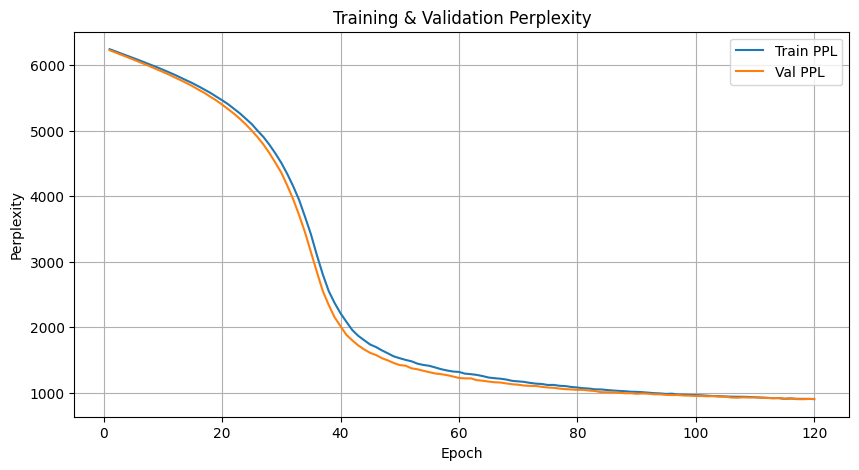

In [21]:
history = train_model(
    lm_model,
    corpus,
    num_tokens=35,       
    vocab_size=len(vocab),
    batch_size=32,       
    lr=0.01,             
    epochs=120,           
    grad_clip_val=1.0,
    device=device
)

plot_training_curves(history)

## Inference

### Functions for Model Validation

In [22]:
def sample_from_logits(logits, temperature=1.0):
    """Sample index from logits with temperature."""
    if temperature <= 0:
        return int(torch.argmax(logits))
    else:
        scaled = logits / temperature
        probs = F.softmax(scaled, dim=-1)
        return int(torch.multinomial(probs, num_samples=1))

def generate_with_embeddings(prefix_tokens, num_preds, model, vocab, device='cpu', temperature=1.0):
    """Generate text using LM."""
    model.eval()
    output_indices = [vocab[token] for token in prefix_tokens]
    state = None
    
    with torch.no_grad():
        # Process prefix
        for i in range(len(prefix_tokens) - 1):
            X = torch.tensor([[output_indices[i]]], device=device)
            embs = model.embedding(X.T)
            _, state = model.cell(embs, state)
        
        # Generate new tokens
        current_idx = output_indices[-1]
        for _ in range(num_preds):
            X = torch.tensor([[current_idx]], device=device)
            embs = model.embedding(X.T)
            rnn_outs, state = model.cell(embs, state)
            
            outs_stacked = torch.stack(rnn_outs, dim=1)
            logits = model.output_proj(outs_stacked)[0, -1, :]
            
            next_idx = sample_from_logits(logits, temperature)  # Use helper
            
            output_indices.append(next_idx)
            current_idx = next_idx
    
    return " ".join(vocab.to_tokens(output_indices))

### Inference Example

In [23]:
# Try different temperatures:
print("\nDifferent temperature examples:")
for temp in [0.5, 0.8, 1.0, 1.2]:
    print(f"\nTemperature {temp}:")
    print(generate_with_embeddings("the time".split(), num_preds=10,
                       model=lm_model, vocab=vocab, device=device, temperature=temp))



Different temperature examples:

Temperature 0.5:
the time and the i the i the and a i the

Temperature 0.8:
the time lighter of mysteries footprints i to a not i i

Temperature 1.0:
the time uncertain, wood proceeded for so and to, eclipse and garments

Temperature 1.2:
the time particular, darted wing. clang. floated mind female, and the questions
